# Import des données

In [1]:
import numpy as np # linear 
import pandas as pd
import csv
import matplotlib.pyplot as plt
import random

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import fbeta_score
from sklearn.linear_model import LogisticRegression

In [2]:
X = np.genfromtxt('X_train.csv')
y = np.genfromtxt('y_train.csv')

X_test_finaux = np.genfromtxt('X_test.csv')
X_test_final = np.genfromtxt('X_test.csv')

## Normalisation et remplacement des nan (par des zéros)

In [3]:
def selectionVariable(data,seuil):
    """
    Prend en paramètre les données et renvoie les indices variables ayant l'écart type le plus important
    """
    lis_sig=[]
    for i in range(X_etude.shape[1]):
        sigma = np.nanstd(X_etude[:,i])
        if sigma>=seuil:
            #print(sigma, i)
            lis_sig.append(i)
    print(len(lis_sig))
    return lis_sig

def NormalisationByYear(data):
    """
    Normalise les données par années en remplaçant les nan par des zéros
    data: array avec comme dernière colonne l'année 
    """
    data_norm = np.copy(data)
    for i in range(2011,2015):
        for k in range(data_norm.shape[1]-1):
            mean = np.nanmean(data_norm[data_norm[:,-1]==i,k])
            std = np.nanstd(data_norm[data_norm[:,-1]==i,k])
            
            data_norm[data_norm[:,-1]==i,k] = (data_norm[data_norm[:,-1]==i,k] - mean)/std
    
    data_norm = np.nan_to_num(data_norm)
    return data_norm

In [5]:
X = np.genfromtxt('X_train.csv')
y = np.genfromtxt('y_train.csv')

X_test_finaux = np.genfromtxt('X_test.csv')
X_test_final = np.genfromtxt('X_test.csv')


X_etude = np.concatenate((X,X_test_final),axis=0)
lis_index = selectionVariable(X_etude,0)
print(lis_index)

X_etude_norm = NormalisationByYear(X_etude)

X_train_norm = X_etude_norm[:X.shape[0],np.array(lis_index)]
X_test_final_norm = X_etude_norm[X.shape[0]:,np.array(lis_index)]


print(X_test_final_norm.shape,X_test_final.shape,X_train_norm.shape)

51
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
(4000, 51) (4000, 51) (8001, 51)


### Création du X_train et du X_test_local

In [6]:
def getTrainTest(X,y,repartition):
    """
    Retourne une répartition train/test aléatoire avec la répartition
    """
    n=X.shape[0]
    shuffle_arr=np.random.rand(n).argsort()
    delim=int(n//(1/repartition))
    #print(delim)
    X2=np.take(X,shuffle_arr,axis=0,out=X)
    y2=np.take(y,shuffle_arr,axis=0,out=y)
    
    X_train=X2[:delim]
    y_train=y2[:delim]
    X_test=X2[delim:]
    y_test=y2[delim:]
    return X_train,y_train,X_test,y_test

# X_train,y_train,X_test,y_test=getTrainTest(X,y,2/3)

### Helper Function:

In [7]:
def arrayToCSV(y,title_file):
    """
    Convertit un array des résultats en un fichier csv dans le format correspondant au challenge
    y: array de 0 signifiant que l'entreprise est saine et 1 sinon
    title_file: nom du fichier de sortie
    """
    fileOut = [0]*(y.shape[0]+1)
    fileOut[0] = "Id,Expected" #Header
    for i in range(y.shape[0]):
        if y[i]==1:
            fileOut[i+1] = str(i)+",True" 
        else:
            fileOut[i+1] = str(i)+",False"
      
    pd.DataFrame(fileOut).to_csv(title_file+".csv",index=False,header=False,sep=" ")

def dataWithPIB_TID(X):
    """
    Crée une base de données similaire à X avec une colonne en plus,cette colonne est occupé par le TID (Taux d'intérêts directeurs)
    de l'année correspondante et la colonne des années par les taux d'accroissement du PIB(indicateur de la croissance) 
    X est la base de donnée 
    """
    X_macro = np.zeros((X.shape[0],X.shape[1]+1))
    X_macro[:,:-2] = X[:,:-1]
    
    tauxPIB = [2.1,0.2,0.6,0.9]
    TID = [1.25,0.75,0.5,0.15]
    
    for i in range(X.shape[0]):
        X_macro[i,-2] = tauxPIB[int(X[i,-1]-2011)]
        X_macro[i,-1] = TID[int(X[i,-1]-2011)]
        
    return X_macro

def CrossValidationF2(estimator, X, y, cv):
    """
    Cross-Validation pour la fonction F2-score
    """
    dataset = np.concatenate((X,np.reshape(y,(y.shape[0],1))),axis=1)
    
    data = dataset[:,:-1]
    label = dataset[:,-1]
    
    scores = np.zeros(cv)
    L=int(data.shape[0])
    
    for i in range(cv):
        data_train = np.concatenate((data[:int((cv-i-1)*L/cv),:],data[int((cv-i)*L/cv):,:]),axis=0)
        data_test = data[int((cv-i-1)*L/cv):int((cv-i)*L/cv),:]
        
        label_train = np.concatenate((label[:int((cv-i-1)*L/cv)],label[int((cv-i)*L/cv):]),axis=0)
        label_test = label[int((cv-i-1)*L/cv):int((cv-i)*L/cv)]
        
        estimator.fit(data_train,label_train)
        label_estim = estimator.predict(data_test)
        scores[i] = fbeta_score(label_test, label_estim, beta=2)
    
    return scores

def creationProfil(data, indexParmeter):
    """
    Sépare en deux data, ceux dont data[indexParmeter]>0 et ceux dont data[indexParmeter]<=0
    """
    ProfilNegatif = data[data[:,indexParmeter]<=0,:]
    ProfilPositif = data[data[:,indexParmeter]>0,:]
    return ProfilNegatif, ProfilPositif

def EntrainementRandomForest():
    return 0

Entrainement sur le profilNegatif(x2normé<=0) du RandomForest le poid Idéal semble être des poids équivalents des deux côtés. Pas de différence notable sur n_estimator (100 c bien). max_depth fait beaucoup varier (en bon) mais doit dont s'y fier hmmmmm?!

In [39]:
data_label = np.concatenate((X_train_norm,np.reshape(y,(y.shape[0],1))),axis=1)
ProfilNegatif, ProfilPositif = creationProfil(data_label,4)

lr = LogisticRegression(solver='liblinear') #class_weight={0:(10-i)/10,1:i/10})
scoresF2 = CrossValidationF2(lr,ProfilNegatif[:,:-1],ProfilNegatif[:,-1],cv=6)
print(np.mean(scoresF2),np.std(scoresF2))

0.9625066881142752 0.004722447230520707


In [ ]:
data_label = np.concatenate((X_train_norm,np.reshape(y,(y.shape[0],1))),axis=1)
ProfilNegatif, ProfilPositif = creationProfil(data_label,4)

for i in range(60,80):
    print(i)
    lr = LogisticRegression(solver='liblinear', class_weight={0:(100-i)/100,1:i/100})
    scoresF2 = CrossValidationF2(lr,ProfilNegatif[:,:-1],ProfilNegatif[:,-1],cv=6)
    print(np.mean(scoresF2),np.std(scoresF2))
    
### ==> 65

In [44]:
data_label = np.concatenate((X_train_norm,np.reshape(y,(y.shape[0],1))),axis=1)
ProfilNegatif, ProfilPositif = creationProfil(data_label,4)

for i in range(70,90):
    print(i)
    lr = LogisticRegression(solver='liblinear', class_weight={0:(100-i)/100,1:i/100})
    scoresF2 = CrossValidationF2(lr,ProfilPositif[:,:-1],ProfilPositif[:,-1],cv=6)
    print(np.mean(scoresF2),np.std(scoresF2))

## ==>Meilleur que RF(0.82) pour weight 1:85/100, 0:15/100

70
0.8150048941035705 0.02981677836536108
71
0.8163946157916744 0.027802727433034132
72
0.8185306376645385 0.0265772027008773
73
0.8250882460573862 0.022948038935924647
74
0.8224675883931319 0.025001864264477435
75
0.8287449462927837 0.028965980125578033
76
0.8407752070224138 0.030668760550876625
77
0.8444701512595558 0.03352141771499146
78
0.8433134836797306 0.03460500963805071
79
0.8373173807493193 0.03706640549794399
80
0.8458451847612335 0.03329441241230498
81
0.850428611609117 0.034322075469751814
82
0.8491767712925133 0.03310162687463756
83
0.8499791322770202 0.03566966465186028
84
0.8491923682373456 0.033818884268590206
85
0.8505494865718984 0.029715961685403428
86
0.8476022188681722 0.028274240540382533
87
0.8483524659447336 0.02683419834274982
88
0.8452872544568919 0.030517238941271042
89
0.8419581038335174 0.03316804660393556


In [43]:
data_label = np.concatenate((X_train_norm,np.reshape(y,(y.shape[0],1))),axis=1)
ProfilNegatif, ProfilPositif = creationProfil(data_label,2)

# Entrainement du premier classifier pour le profil Negatif où il y a 71,3% de faillite:
# for i in range(100,60):
#     print(i)
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0) #class_weight={0:0.8,1:0.2})
scoresF2 = CrossValidationF2(clf,ProfilPositif[:,:-1],ProfilPositif[:,-1],cv=6)
print(np.mean(scoresF2),np.std(scoresF2))
scores = cross_val_score(clf,ProfilPositif[:,:-1],ProfilPositif[:,-1],cv=6)
print(np.mean(scores),np.std(scores))

0.8234487582528399 0.031187358795192015
0.9393476185401773 0.01106512387889858


In [9]:
data_label = np.concatenate((X_train_norm,np.reshape(y,(y.shape[0],1))),axis=1)
ProfilNegatif, ProfilPositif = creationProfil(data_label,2)

# Entrainement du premier classifier pour le profil Positif où il y a 9.9% de faillite:
for i in range(2,10):
    print(i)
    clf = RandomForestClassifier(n_estimators=100, max_depth=i,random_state=0, class_weight={0:23/100,1:77/100})
    scoresF2 = CrossValidationF2(clf,ProfilPositif[:,:-1],ProfilPositif[:,-1],cv=6)
    print(np.mean(scoresF2),np.std(scoresF2))
# scores = cross_val_score(clf,ProfilPositif[:,:-1],ProfilPositif[:,-1],cv=6)
# print(np.mean(scores),np.std(scores))

2
0.9241612797568122 0.007286502650177789
3
0.9492170695921925 0.007364375490236709
4
0.9646545712949992 0.009832504260041734
5


KeyboardInterrupt: 

In [ ]:
data_label = np.concatenate((X,np.reshape(y,(y.shape[0],1))),axis=1)
ProfilNegatif, ProfilPositif = creationProfil(data_label)

X_train_ProfilNegatif, y_train_ProfilNegatif = ProfilNegatif[:,:-1], ProfilNegatif[:,-1]
X_train_ProfilPositif, y_train_ProfilPositif = ProfilPositif[:,:-1], ProfilPositif[:,-1]

X_test_ProfilNegatif, X_test_ProfilPositif = creationProfil(X_test)

clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(X_train_ProfilNegatif, y_train_ProfilNegatif)
y_estim_ProfilNegatif = clf.predict(X_test_ProfilNegatif)

# Visualitation de deux profil à partir d'un critère:

In [19]:
def ratio(X,k):
    '''
    Visualition du ratio de faillite en fonction du critère k'''
    nbrSaineBFRPositif = 0
    nbrSaineBFRNegatif = 0
    nbrFailliteBFRPositif = 0
    nbrFailliteBFRNegatif = 0
    for i in range(X.shape[0]):
        if X[i,k]>0:
            if y[i]==0:
                nbrSaineBFRPositif += 1
            else:
                nbrFailliteBFRPositif += 1
        else:
            if y[i]==0:
                nbrSaineBFRNegatif += 1
            else:
                nbrFailliteBFRNegatif += 1
    print("rapport faillite sur (faillite+saine) pour le paramètre", k, "positif:", nbrFailliteBFRPositif/(nbrFailliteBFRPositif+nbrSaineBFRPositif))
    print("rapport faillite sur (faillite+saine) pour le paramètre", k, "negatif:", nbrFailliteBFRNegatif/(nbrFailliteBFRNegatif+nbrSaineBFRNegatif))
    print()


for j in range(0,X_train_norm.shape[1]):
    ratio(X_train_norm,j)

rapport faillite sur (faillite+saine) pour le paramètre 0 positif: 0.09475806451612903
rapport faillite sur (faillite+saine) pour le paramètre 0 negatif: 0.5926608321817902

rapport faillite sur (faillite+saine) pour le paramètre 1 positif: 0.17779868297271872
rapport faillite sur (faillite+saine) pour le paramètre 1 negatif: 0.6166808510638297

rapport faillite sur (faillite+saine) pour le paramètre 2 positif: 0.26995905834186285
rapport faillite sur (faillite+saine) pour le paramètre 2 negatif: 0.7197654532128024

rapport faillite sur (faillite+saine) pour le paramètre 3 positif: 0.2694767441860465
rapport faillite sur (faillite+saine) pour le paramètre 3 negatif: 0.6739750054812541

rapport faillite sur (faillite+saine) pour le paramètre 4 positif: 0.09873873873873874
rapport faillite sur (faillite+saine) pour le paramètre 4 negatif: 0.7131649445082281

rapport faillite sur (faillite+saine) pour le paramètre 5 positif: 0.46653965229816624
rapport faillite sur (faillite+saine) pour l

ZeroDivisionError: division by zero

## Création d'une méthode avec profil < ou > à 0:

x10 correspond au Quick Assets/Current Liabilities ("measures the ability of a business to pay its short-term liabilities by having assets")

On définit donc deux profils, l'un ayant un x10<0 alors il y a 78,8% de risque que l'entreprise soit en faillite, et l'autre profil x10>0 et il y a 9,6% de risque que l'entreprise soit en faillite.

In [4]:
# X = np.genfromtxt('X_train.csv')
# X_test_final = np.genfromtxt('X_test.csv')
# y = np.genfromtxt('y_train.csv')

# X = np.nan_to_num(X)
# X_test_final = np.nan_to_num(X_test_final)

# data_label = np.concatenate((X,np.reshape(y,(y.shape[0],1))),axis=1)

# def creationProfil(data):
#     """
#     Sépare en deux les données en entrées selon le critère x10 < ou > 0
#     """
#     ProfilNegatif = data[data[:,9]<=0,:]
#     ProfilPositif = data[data[:,9]>0,:]
#     return ProfilNegatif, ProfilPositif

In [5]:
def NaiveBayesian(X,X_test):
    '''
    Machine learning à partir de la méthode NaiveBayesian en utilisant la séparation par profil
    '''
    y_estim = np.zeros(X_test.shape[0])
    
    data_label = np.concatenate((X,np.reshape(y,(y.shape[0],1))),axis=1)
    ProfilNegatif, ProfilPositif = creationProfil(data_label)
    
    X_train_ProfilNegatif, y_train_ProfilNegatif = ProfilNegatif[:,:-1], ProfilNegatif[:,-1]
    X_train_ProfilPositif, y_train_ProfilPositif = ProfilPositif[:,:-1], ProfilPositif[:,-1]
    
    X_test_ProfilNegatif, X_test_ProfilPositif = creationProfil(X_test)
    
    gnb = GaussianNB()
    gnb.fit(X_train_ProfilNegatif, y_train_ProfilNegatif)
    y_estim_ProfilNegatif = gnb.predict(X_test_ProfilNegatif)
    
    gnb = GaussianNB()
    gnb.fit(X_train_ProfilPositif, y_train_ProfilPositif)
    y_estim_ProfilPositif = gnb.predict(X_test_ProfilPositif)
    k=0
    j=0
    for i in range(X_test.shape[0]):
        if X_test[i,9]<=0:
            y_estim[i] = y_estim_ProfilNegatif[k]
            k += 1
        else:
            y_estim[i] = y_estim_ProfilPositif[j]
            j += 1
    return y_estim

y_estim_final = NaiveBayesian(X,X_test_final)
arrayToCSV(y_estim_final,"NaiveBayesianWithProfil")

In [15]:
def RandomForest(X,X_test,y,indexparameter):
    '''
    Machine learning à partir de la méthode RandomForest en utilisant la séparation par profil
    '''
    y_estim = np.zeros(X_test.shape[0])
    
    data_label = np.concatenate((X,np.reshape(y,(y.shape[0],1))),axis=1)
    ProfilNegatif, ProfilPositif = creationProfil(data_label,indexparameter)
    
    X_train_ProfilNegatif, y_train_ProfilNegatif = ProfilNegatif[:,:-1], ProfilNegatif[:,-1]
    X_train_ProfilPositif, y_train_ProfilPositif = ProfilPositif[:,:-1], ProfilPositif[:,-1]
    
    X_test_ProfilNegatif, X_test_ProfilPositif = creationProfil(X_test,indexparameter)
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0, class_weight={0:57/100,1:43/100})
    clf.fit(X_train_ProfilNegatif, y_train_ProfilNegatif)
    y_estim_ProfilNegatif = clf.predict(X_test_ProfilNegatif)
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0, class_weight={0:23/100,1:77/100})
    clf.fit(X_train_ProfilPositif, y_train_ProfilPositif)
    y_estim_ProfilPositif = clf.predict(X_test_ProfilPositif)
    
    k=0
    j=0
    for i in range(X_test.shape[0]):
        if X_test[i,indexparameter]<=0:
            y_estim[i] = y_estim_ProfilNegatif[k]
            k += 1
        else:
            y_estim[i] = y_estim_ProfilPositif[j]
            j += 1
    return y_estim

# y_estim_final = RandomForest(X,X_test_final)
# arrayToCSV(y_estim_final,"RandomForestWithProfil")

In [13]:

scores = np.zeros(6)
for i in range(0,6):
    X_train,y_train,X_test,y_test=getTrainTest(X_train_norm,y,5/6)
    y_estim = RandomForest(X_train,X_test,y_train,3)
    scores[i] = fbeta_score(y_test, y_estim, beta=2)
print(j, np.mean(scores),np.std(scores))
print()
# data_label = np.concatenate((X,np.reshape(y,(y.shape[0],1))),axis=1)


4 0.9908912011127767 0.0019787081247463366



In [16]:
y_estim_final = RandomForest(X_train_norm,X_test_final_norm,y,3)
arrayToCSV(y_estim_final,"RandomForestAvecProfilEtNormEtSelectEt3bisbis")

# Etude priliminaire sur les données et les différentes méthodes possibles:

# Random Forest:

In [12]:
#X, y = make_classification(n_samples=1000, n_features=4,n_informative=2, n_redundant=0,random_state=0, shuffle=False)

clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
scores = CrossValidationF2(clf,X_train_norm,y,cv=6)
print(np.mean(scores),np.std(scores))

0.9105654165541375 0.007797614086033565


In [11]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=0)
clf.fit(X_train_norm,y)
y_estim_finauxRF = clf.predict(X_test_final_norm)
arrayToCSV(y_estim_finauxRF,"RandomForestAvecProfondeurEtNormEtSelect")

## Naive Bayesian:

In [40]:
gnb = GaussianNB()
scores = CrossValidationF2(gnb,X_train_norm,y,cv=6)
print(np.mean(scores),np.std(scores))

0.3497304699027468 0.09794020760856348


In [8]:
gnb.fit(X_train_norm)
y_estim_finauxNB = gnb.predict(X_test_finaux)
y_estim_finauxNB

array([1., 1., 1., ..., 0., 0., 1.])

# Algorithme PCA

In [68]:
X_2=np.copy(X)
X_means={}
X_stds={}

X_means[2011]=np.array([0]*X.shape[1])
X_stds[2011]=np.array([1]*X.shape[1])

X_test_final_2=np.copy(X_test_finaux)
X_means[2012]=np.nanmean(X[X[:,-1]==2012], axis=0)
X_stds[2012]=np.nanstd(X[X[:,-1]==2012],axis=0)
X_means[2012][-1]=0;X_stds[2012][-1]=1

X_means[2013]=np.nanmean(X[X[:,-1]==2013], axis=0)
X_stds[2013]=np.nanstd(X[X[:,-1]==2013],axis=0)
X_means[2013][-1]=0;X_stds[2013][-1]=1

def normalizeRow(x):
    return (x-X_means[x[-1]])/X_stds[x[-1]]

X_2=np.apply_along_axis(normalizeRow, 1, X_2)

X_means[2013]=np.array([0]*X.shape[1])
X_stds[2013]=np.array([1]*X.shape[1])
    
X_means[2014]=np.nanmean(X_test_finaux[X_test_finaux[:,-1]==2014], axis=0)
X_stds[2014]=np.nanstd(X_test_finaux[X_test_finaux[:,-1]==2014],axis=0)
X_means[2014][-1]=0;X_stds[2014][-1]=1

X_test_final_2=np.apply_along_axis(normalizeRow, 1, X_test_final_2)

X_con =np.concatenate((X_2,X_test_final_2),axis=0)
X_con = X_con[:,:-1]

X_2_macro = np.nan_to_num(dataWithPIB_TID(X_2))
X_2 = np.nan_to_num(X_2)

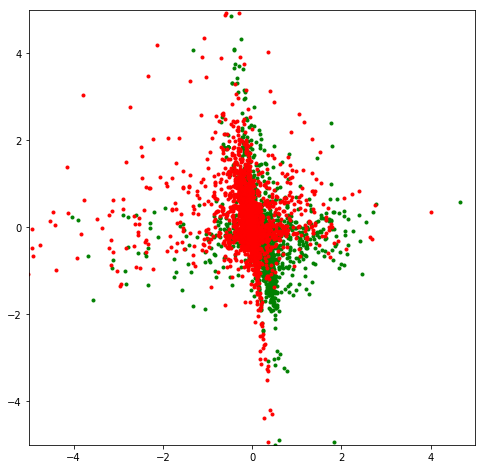

In [69]:
pca = PCA()
X_new = pca.fit_transform(X_train_norm)

X_saine = X_new[:8001,:][y==0,:]
X_faillite = X_new[:8001,:][y==1,:]

X_saine2011 = X_saine[X[y==0,-1]==2011,:]
X_saine2012 = X_saine[X[y==0,-1]==2012,:]
X_saine2013 = X_saine[X[y==0,-1]==2013,:]

X_faillite2011 = X_faillite[X[y==1,-1]==2011,:]
X_faillite2012 = X_faillite[X[y==1,-1]==2012,:]
X_faillite2013 = X_faillite[X[y==1,-1]==2013,:]

# X_test_finaux2013 = X_new[8001:,:][X_test_finaux[:,-1]==2013]
# X_test_finaux2014 = X_new[8001:,:][X_test_finaux[:,-1]==2014]

i=0

plt.figure(figsize=(8,8))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.plot(X_saine2011[:,i],X_saine2011[:,i+1],'g.')
plt.plot(X_saine2012[:,i],X_saine2012[:,i+1],'g.')
plt.plot(X_saine2013[:,i],X_saine2013[:,i+1],'g.')
# plt.plot(X_faillite2011[:,2],X_faillite2011[:,1],'rx')
plt.plot(X_faillite2011[:,i],X_faillite2011[:,i+1],'r.')
plt.plot(X_faillite2012[:,i],X_faillite2012[:,i+1],'r.')
plt.plot(X_faillite2013[:,i],X_faillite2013[:,i+1],'r.')
plt.show()

# plt.figure(figsize=(8,8))
# plt.xlim(-20, 20)
# plt.ylim(-10, 10)
# plt.plot(X_test_finaux2013[:,i],X_test_finaux2013[:,i+1],'b+')
# plt.plot(X_test_finaux2014[:,i],X_test_finaux2014[:,i+1],'r+')
# plt.show()

In [70]:
print(X_new[:,:2].shape)
qda = QuadraticDiscriminantAnalysis()
# print(qda.fit(X_new[:,:2],y))
scores = cross_val_score(qda, X_new[:,:2], y, cv=5)
np.mean(scores),np.std(scores)

(8001, 2)


(0.5118102748282324, 0.00749926281339346)

### Corrélation entre les données:

In [17]:
X1 = X[:,:-1]
df = pd.DataFrame(X1)
L = np.linspace(-1,1,21)
labels = np.linspace(1,13,13)
labels
X1.shape

(8001, 50)

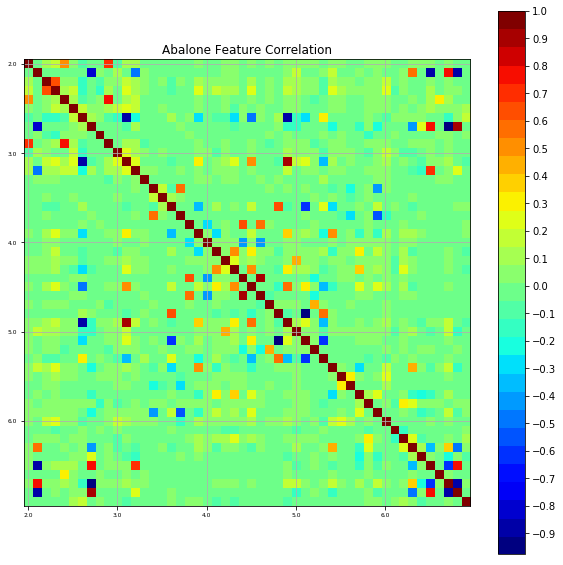

In [18]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Abalone Feature Correlation')
    ax1.set_xticklabels(labels,fontsize=6)
    ax1.set_yticklabels(labels,fontsize=6)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=L)
    plt.show()

correlation_matrix(df)

## Rajout d'un indice macro économique:

Il existe 4 indicateurs macro-économique:
* Croissance = Taux d'accroissement du PIB (2011=2.1%, 2012=0.2%, 2013=0.6%, 2014=0.9%)
* Taux d'intérêts directeurs (2011=1.25%,2012=0.75%, 2013=0.5%, 2014=0.15%)
* Taux de Chômage (2011=9.6%,2012=9.8%,2013=10.2%,2014=10.3%)
* Balance des paiements

==> Création de la fonction dataWithPIB_TID() pour rajouter Croissance et Taux d'interets directeurs, pour l'instant pas de différence sur la PCA!

# Etude de Profil différents (clustering):

### TSNE suivie d'une QDA:

In [52]:
# X = np.genfromtxt('X_train.csv')
# X_test_final = np.genfromtxt('X_test.csv')
# y = np.genfromtxt('y_train.csv')
X_total_cluster = np.nan_to_num(np.concatenate((X_train_norm,X_test_final_norm),axis=0))

In [53]:
#X_total_cluster = np.nan_to_num(np.concatenate((X,X_test_final),axis=0))
# X_test_final_cluster = np.nan_to_num(X_test_final)
X_total_cluster = TSNE(n_components=2).fit_transform(X_total_cluster)
# X_test_final_cluster = TSNE(n_components=2).transform(X_test_final_cluster)

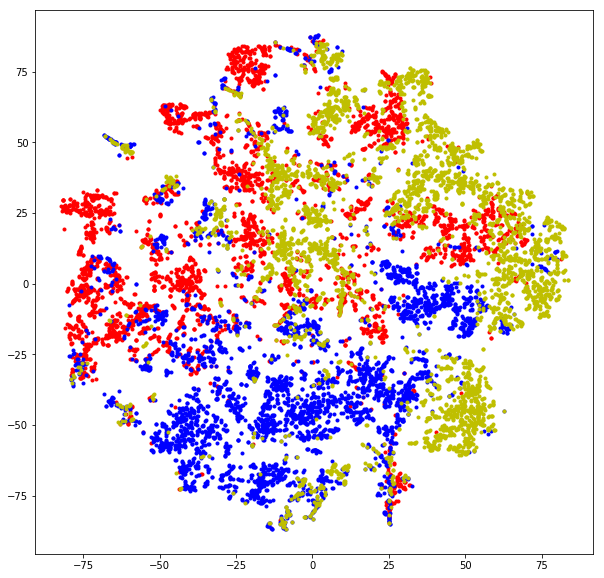

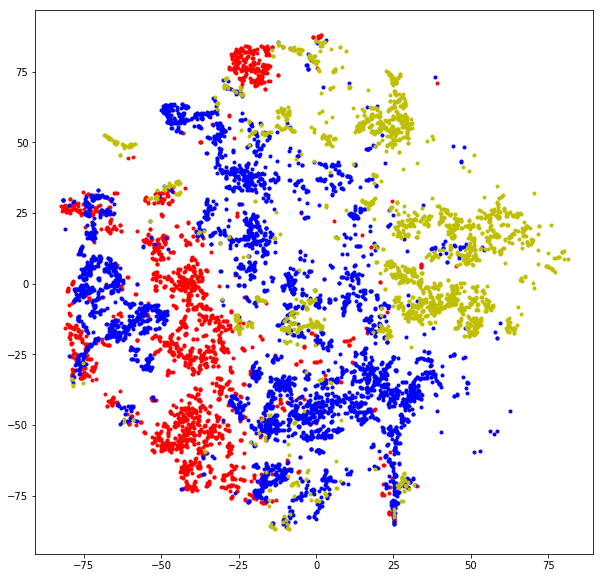

In [54]:
X_train_cluster = X_total_cluster[:8001,:]
X_test_final_cluster = X_total_cluster[8001:,:]
X_train_cluster_faillite = X_train_cluster[y==1,:]
X_train_cluster_saine = X_train_cluster[y==0,:]

plt.figure(figsize=(10,10))
plt.plot(X_train_cluster_faillite[:,0],X_train_cluster_faillite[:,1],'r.')
plt.plot(X_train_cluster_saine[:,0],X_train_cluster_saine[:,1],'b.')
plt.plot(X_test_final_cluster[:,0],X_test_final_cluster[:,1],'y.')
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X_train_cluster[X[:,-1]==2011,0],X_train_cluster[X[:,-1]==2011,1],'r.')
plt.plot(X_train_cluster[X[:,-1]==2012,0],X_train_cluster[X[:,-1]==2012,1],'b.')
plt.plot(X_train_cluster[X[:,-1]==2013,0],X_train_cluster[X[:,-1]==2013,1],'y.')
plt.show()

In [64]:
qda = QuadraticDiscriminantAnalysis()
# print(qda.fit(X_train_cluster,y))
scores = cross_val_score(qda, X_train_cluster, y, cv=5)
np.mean(scores),np.std(scores)

(0.8351448313554029, 0.003399559858910214)

In [125]:
qda.fit(X_train_cluster,y)
y_estim_final = qda.predict(X_test_final_cluster)

arrayToCSV(y_estim_final,"TSNEsuivieQDA")